In [4]:
# Get the dataset from github.
# This is the same dataset as Lab 5A, so you can also use the dataset you downloaded for that lab.
!git clone https://github.com/Damowerko/ese2000-dynamical-systems.git

fatal: destination path 'ese2000-dynamical-systems' already exists and is not an empty directory.


In [5]:
import sys
sys.path.append('./ese2000-dynamical-systems/')

from pathlib import Path
import matplotlib.style
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import torch
from tqdm.notebook import trange
import torch
torch.set_float32_matmul_precision("medium")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from ese2000_dynamical.config import Config
from ese2000_dynamical.track import load_track, Track
from ese2000_dynamical.simulator import Simulator, dynamics_ca

# matplotlib settings
matplotlib.style.use("seaborn-v0_8-colorblind")
plt.rcParams["figure.dpi"] = 150

data_path = Path("./ese2000-dynamical-systems/data")
figure_path = Path("figures")

In [26]:
# Select an example expert trajectory for the sake of plotting
expert_idx = 5

# Load the dataset and the track
t = np.arange(0, Config.duration, Config.time_step)
x_experts = np.load(data_path / "states.npy")
u_experts = np.load(data_path / "inputs.npy")
track = load_track(data_path / "track.npz")

# Load the pre-trained model from Lab 5A
# We've given you a parameterization but you can also save the model from your previous lab and load it here.
A_learnt = np.load("weights/A.npy")
B_learnt = np.load("weights/B.npy")

In [27]:
def plot_vs_expert(x, x_label: str, x_expert, track: Track):
    """
    Plot a given trajectory and expert trajectory on the same plot.

    Args:
        x: The trajectory to plot.
        x_label: The label for the trajectory.
        x_expert: The expert trajectory.
        track: The track to plot.
    """

    plt.figure()
    track.plot()
    plt.grid(True)
    plt.xlabel("x (m)")
    plt.ylabel("y (m)")
    plt.plot(x_expert[:, 0], x_expert[:, 1], "--", label="Expert")
    plt.plot(x[:, 0], x[:, 1], "-", label=x_label)
    plt.legend(loc="upper right", framealpha=1.0)

def rollout(A, B, u, x0):
    """
    Integrate the system dynamics to predict the trajectory.

    Args:
        A: (4, 4) The state transition matrix.
        B: (4, 2) The input matrix.
        u: (T, 2) The control inputs.
        x0: (4,) The initial state.
    """
    x = torch.zeros((len(u) + 1, A.shape[0]), device=A.device)
    x[0] = x0
    for i in range(len(u)):
        x[i + 1] = x[i] @ A.T + u[i] @ B.T
    return x[1:]

In [28]:
def calculate_reference(
    state: npt.NDArray[np.floating],
    x_expert: npt.NDArray[np.floating],
    horizon: int,
):
    """
    Calculate the reference trajectory based on the expert trajectory and time horizon.

    Args:
        state: (4,) array with current state (x, y, vx, vy)
        x_expert: (T, 4) array with expert trajectory
        horizon: int with the time horizon

    Returns:
        x_ref: (horizon, 4) array with reference trajectory
    """
    # Find the nearest point in the expert trajectory based on current position
    nearest_idx = np.argmin(np.linalg.norm(x_expert[:, :2] - state[:2], axis=1))

    # Get the windowed reference trajectory based on the nearest point
    ref_idx = np.arange(nearest_idx + 1, nearest_idx + horizon + 1) % len(x_expert)

    return x_expert[ref_idx]


def mpc_controller(
    state: npt.NDArray[np.floating],
    state_matrix: npt.NDArray[np.floating],
    input_matrix: npt.NDArray[np.floating],
    x_ref: npt.NDArray[np.floating],
):
    """MPC controller.

    Args:
        state: (4,) array with current state
        state_matrix A: (4,4) array with state matrix
        B: (4,2) array with input matrix
        x_ref: (horizon,4) array with reference trajectory

    Returns:
        u: (M,) array with control input
    """
    # We learnt the A and B matrices in Lab 5A
    # Now we keep them fixed and learn actions, u
    A = torch.from_numpy(state_matrix).to(device)
    B = torch.from_numpy(input_matrix).to(device)

    x_ref_tensor = torch.tensor(x_ref, device=device).float()

    # Initialize x to the reference trajectory
    x0 = torch.tensor(state, device=device).float()

    # Initialize u to zero
    # Notice that u is going to be learned
    # u is also sized to match the input matrix and the horizon length
    u = (
        torch.zeros(len(x_ref), input_matrix.shape[1], device=device)
        .float()
        .requires_grad_(True)
    )

    # Use Adam optimizer to learn u
    optimizer = torch.optim.Adam([u], lr=1.0)

    loss_mpc = 0
    for _ in range(50):
        optimizer.zero_grad()

        # Rollout the system (predict the trajectory)
        x = rollout(A, B, u, x0)

        # Quadratic loss
        loss = (x - x_ref_tensor).pow(2).mean()

        # Backpropagation
        loss.backward()

        # Loss for logging
        loss_mpc += loss.item()

        # Update u
        optimizer.step()

    # Return the control input and the loss
    # Notice that we detach u from the computational graph
    return u.detach().cpu().numpy(), loss_mpc/50

In [29]:
# Simulate the trajectory
simulator = Simulator()
x_expert = x_experts[expert_idx]

# Define parameters and initialize tensors
n_laps = 3
t = np.arange(0, Config.duration * n_laps, Config.time_step)
x_mpc = np.zeros((len(t), A_learnt.shape[0]))

# use the same starting point as the expert
x_mpc[0] = x_expert[0]

loss_evolution = []
for i in range(len(t) - 1):
    # Compute reference
    x_ref = calculate_reference(x_mpc[i], x_expert, horizon=10)

    # Find best action u
    u_mpc, loss = mpc_controller(x_mpc[i], A_learnt, B_learnt, x_ref)
    loss_evolution.append(loss)

    # Simulate next state
    x_mpc[i + 1] = simulator.step(x_mpc[i], u_mpc[0])

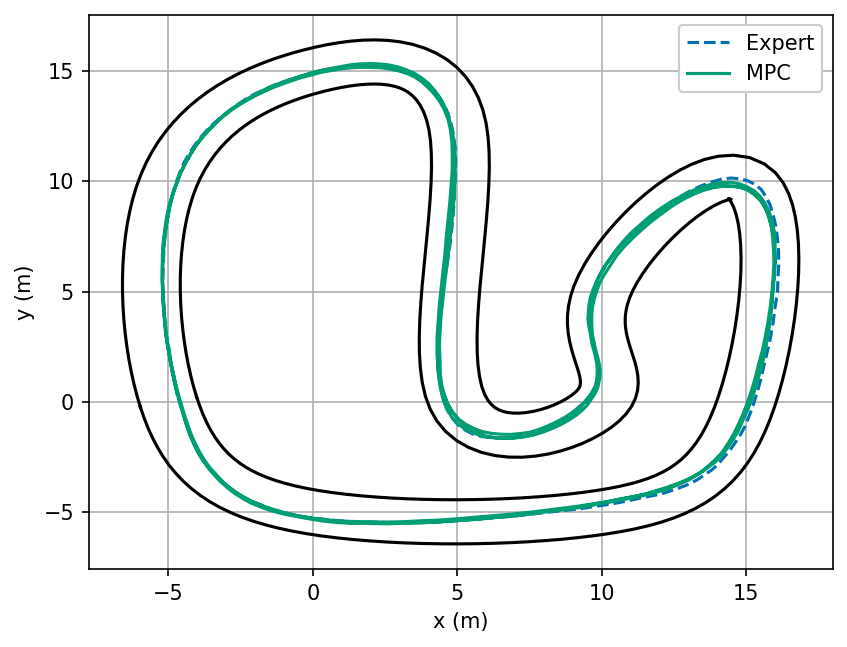

In [30]:
plot_vs_expert(x_mpc, "MPC", x_expert, track)

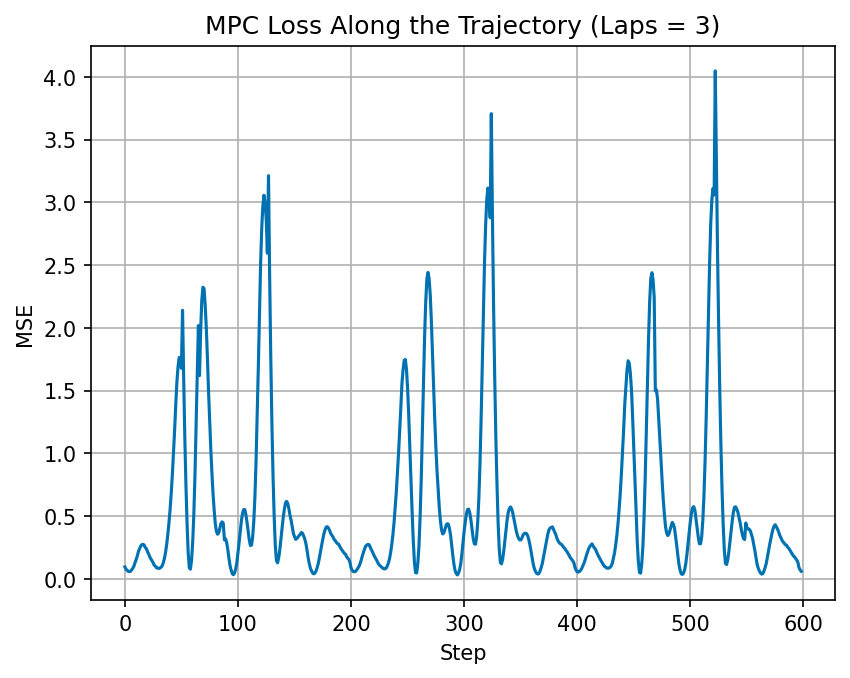

In [31]:
# Plot the loss evolution
plt.figure()
plt.plot(loss_evolution)
plt.xlabel("Step")
plt.ylabel("MSE")
plt.title(f"MPC Loss Along the Trajectory (Laps = {n_laps})")
plt.grid(True)
plt.show()

RuntimeError: Requested MovieWriter (ffmpeg) not available

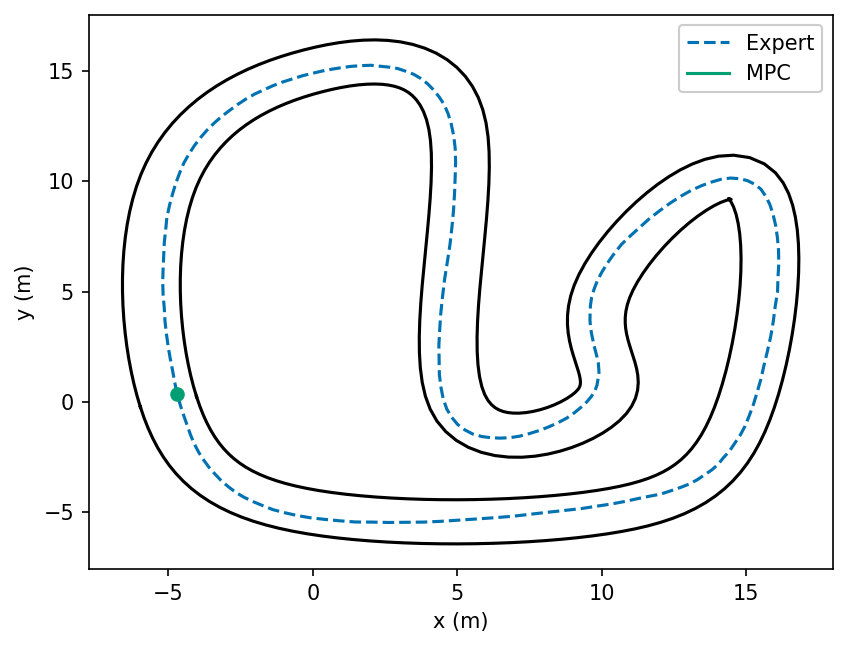

In [32]:
from matplotlib.animation import FuncAnimation
from IPython.core.display import HTML

# Get the color palette
prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]

# For visualization purposes, we will plot the last 10 steps
trail_length = 10

# Plot the track and the expert trajectory
plt.figure()
track.plot(plt.gca())
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.plot(x_expert[:, 0], x_expert[:, 1], "--", label="Expert")
trail = plt.plot([], [], "-", c=colors[1], label="MPC")[0]
current_position = plt.plot([], [], "o", c=colors[1])[0]
plt.legend(loc="upper right", framealpha=1.0)

# Animate our model's trajectory
def animate(i: int):
    trail_idx = slice(max(i - trail_length, 0), i + 1)
    trail.set_data(x_mpc[trail_idx, 0], x_mpc[trail_idx, 1])
    current_position.set_data([x_mpc[i, 0]], [x_mpc[i, 1]])
    return trail, current_position

# HTML5 video
ani = FuncAnimation(
    plt.gcf(), animate, frames=len(t), interval=int(1000 * Config.time_step), blit=True
)
display(HTML(ani.to_html5_video()))
plt.close()

Task 2

In [33]:
from torch.utils.data import TensorDataset, DataLoader

# First, we need to generate a dataset for training a new model that imitates the MPC controller we just implemented.
# Remember, we're doing this because the MPC controller is computationally expensive and we want to learn a faster model.
rng = np.random.default_rng()
std_noise = 0.3

# Generate the normal noise with mean 0 and standard deviation 0.3
means = np.zeros_like(x_expert)
noise = rng.normal(means, scale=std_noise)

# Generate perturbed initial states (Dithering)
x0_imitation = x_expert + noise

# Initialize reference and action tensors
x_ref_imitation = np.zeros_like(x_expert)
u_imitation = np.zeros((len(x_expert), B_learnt.shape[1]))

for i in range(len(x0_imitation)):
    # Compute reference
    x_ref = calculate_reference(x0_imitation[i], x_expert, horizon=10)

    # Compute MPC action
    u_mpc, _ = mpc_controller(x0_imitation[i], A_learnt, B_learnt, x_ref)

    # Save imitation learning point
    x_ref_imitation[i] = x_ref[0]

    u_imitation[i] = u_mpc[0]

# PyTorch tensors for training
error_train = (
    torch.from_numpy(x0_imitation - x_ref_imitation).to(device).float().reshape(-1, 4)
)
u_train = torch.from_numpy(u_imitation).to(device).float().reshape(-1, 2)

imitation_dataset = TensorDataset(error_train, u_train)

In [34]:
# Let's train a model to imitate the MPC controller. We will use a simple linear model for this task.
# The inputs are the error between the current state and the reference state.
# The outputs are the control inputs to our car, u.

# Training parameters
lr = 0.1
n_epochs = 100
batch_size = 32

# Intitialize theta (our parameterization)
# Notice, we are going to learn theta
theta_tensor = torch.randn(2, 4, device=device, requires_grad=True)
optimizer = torch.optim.Adam([theta_tensor], lr=lr)

# Create the dataloader
imitation_loader = DataLoader(imitation_dataset, batch_size=batch_size, shuffle=True)

epoch_loss = np.zeros(n_epochs)
print_every = 10

# Full passes over the dataset
for e in range(n_epochs):
    for error, u in imitation_loader:
        optimizer.zero_grad()

        # Predict action u
        u_hat = error @ theta_tensor.T

        # Evaluate quadratic loss
        loss = (u - u_hat).pow(2).mean()

        # Compute gradients
        loss.backward()

        # Update parameters
        optimizer.step()

        epoch_loss[e] += loss.item()

    # Print progress
    if e%10 == 0:
      print(f" Epoch: {e} \tLoss: {epoch_loss[e]/len(imitation_loader):.2f}")
epoch_loss /= len(imitation_loader)

 Epoch: 0 	Loss: 123.15
 Epoch: 10 	Loss: 50.92
 Epoch: 20 	Loss: 30.87
 Epoch: 30 	Loss: 25.03
 Epoch: 40 	Loss: 23.30
 Epoch: 50 	Loss: 24.16
 Epoch: 60 	Loss: 23.61
 Epoch: 70 	Loss: 23.50
 Epoch: 80 	Loss: 26.80
 Epoch: 90 	Loss: 25.01


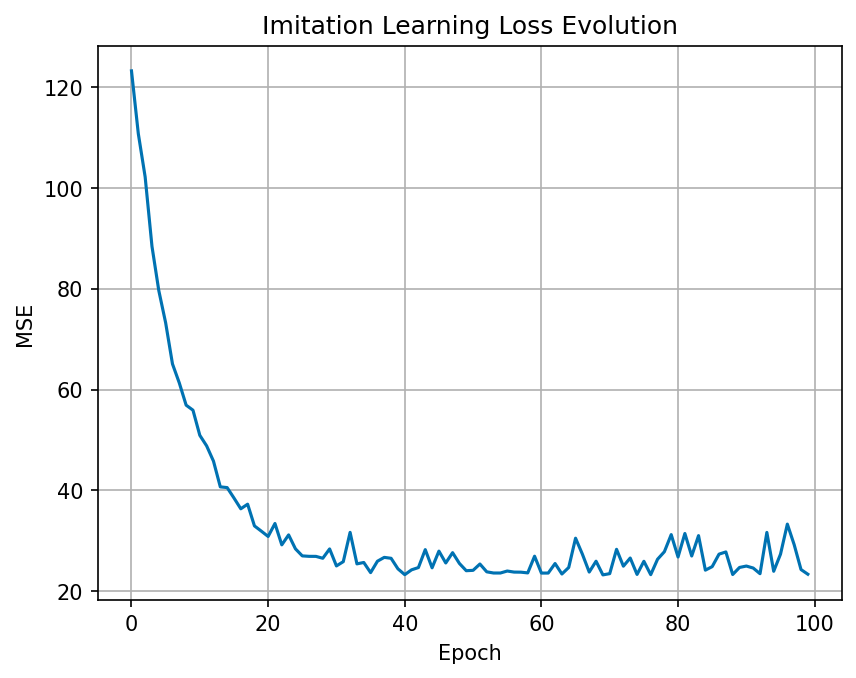

In [35]:
plt.plot(epoch_loss)
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Imitation Learning Loss Evolution")
plt.grid()

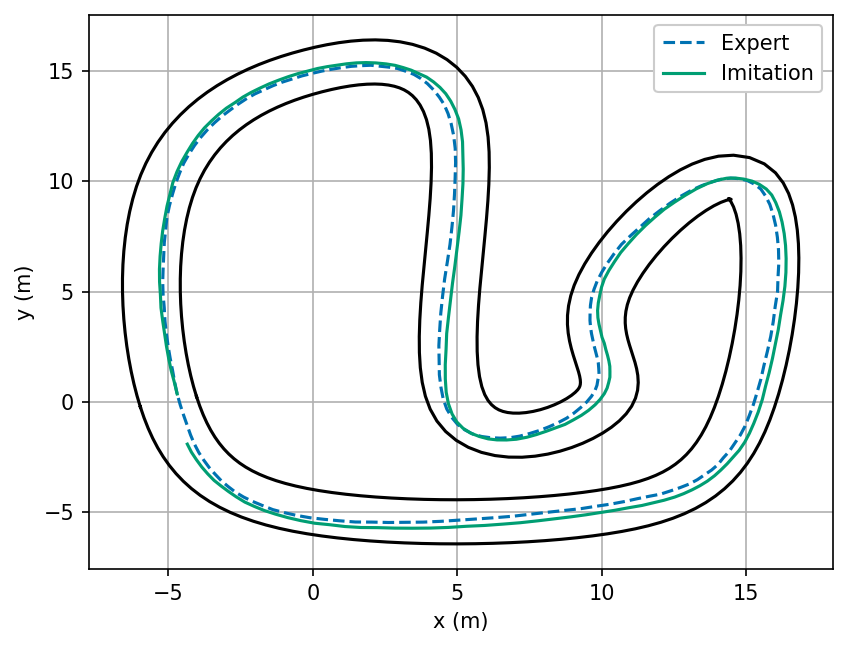

In [36]:
# Simulate the trajectory
n_laps = 1
simulator = Simulator()

t = np.arange(0, Config.duration * n_laps, Config.time_step)
x_imitation = np.zeros((len(t), A_learnt.shape[0]))

# Use the same starting point as the expert
x_imitation[0] = x_expert[0]

# Detaching our model from the computational graph
theta = theta_tensor.detach().cpu().numpy()

error = np.zeros(len(t) - 1)

with torch.no_grad():
    for i in range(len(t) - 1):
        x_ref = calculate_reference(x_imitation[i], x_expert, horizon=1)[0]
        diff = x_imitation[i] - x_ref
        error[i] = (diff[:2]**2).mean() + (diff[2:]**2).mean()
        u_imitation = (diff) @ theta.T
        x_imitation[i + 1] = simulator.step(x_imitation[i], u_imitation)

plot_vs_expert(x_imitation, "Imitation", x_expert, track)

(199,)


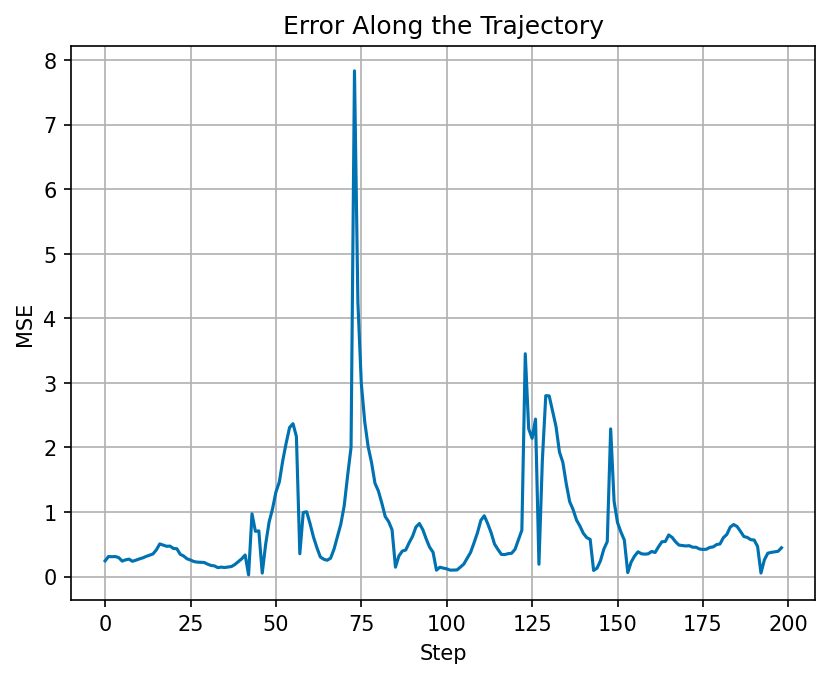

In [37]:
# Plot the error evolution
print(error.shape)
plt.figure()
plt.plot(error)
plt.xlabel("Step")
plt.ylabel("MSE")
plt.title("Error Along the Trajectory")
plt.grid(True)
plt.show()

Task 3

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

def GenerateDataset(x_expert: npt.NDArray[np.floating], W: int, std_noise: float = 0.3):
    """
    Generate a dataset for imitation learning.

    Args:
        x_expert: (T, 4) array with expert trajectory
        A: (4, 4) array with state matrix
        B: (4, 2) array with input matrix
        W: int with the time horizon
    """

    # First, we need to generate a dataset for training a new model that imitates the MPC controller we just implemented.
    # Remember, we're doing this because the MPC controller is computationally expensive and we want to learn a faster model.
    rng = np.random.default_rng()

    # Generate the normal noise with mean 0 and standard deviation 0.3
    means = np.zeros_like(x_expert)
    noise = rng.normal(means, scale=std_noise)

    # Generate perturbed initial states (Dithering)
    x0_imitation = x_expert + noise

    # Initialize reference and action tensors
    x_ref_imitation = np.zeros((len(x0_imitation), W, 4))

    for i in range(len(x0_imitation)):
        # Compute reference
        x_ref = calculate_reference(x0_imitation[i], x_expert, horizon=W)

        # Save imitation learning point
        x_ref_imitation[i] = x_ref

    x0_imitation_tensor = torch.from_numpy(x0_imitation).to(device).float().reshape(-1, 4)
    x_ref_imitation_tensor = torch.from_numpy(x_ref_imitation).to(device).float().reshape(-1, W, 4)

    return x0_imitation_tensor, x_ref_imitation_tensor

# Empty tensors which we can concatenate to
x0_imitation = torch.empty(0, 4)
x_ref_imitation = torch.empty(0, 10, 4)

W = 10

for xprt in x_experts:
    x0, x_ref = GenerateDataset(xprt, W=W, std_noise=0.95)
    x0_imitation = torch.cat((x0_imitation, x0), dim=0)
    x_ref_imitation = torch.cat((x_ref_imitation, x_ref), dim=0)

task3_dataset = TensorDataset(x0_imitation, x_ref_imitation)

In [ ]:
def MPCLoss(x_ref, x_0, A, B, theta,  W=10):
    """
    Compute the MPC loss.

    Args:
        x_ref: The reference trajectory.
        x_hat: The predicted trajectory.
        A: The state matrix.
        B: The input matrix.
        theta: The parameterization.
        W: The time horizon.

    Returns:
        loss: The MPC loss.
    """
    loss_mpc = 0
    x_hat = torch.zeros_like(x_ref)
    x_hat[:,0] = x_0
    for s in range(W-1):
        loss_mpc += (x_hat[:,s] - x_ref[:,s]).pow(2).mean()
        u_hat = (x_hat[:,s] - x_ref[:,s]) @ theta.T
        x_hat[:,s + 1] = x_hat[:,s] @ A.T + u_hat @ B.T
    return loss_mpc / W

# Training parameters
lr = 0.1
n_epochs = 100
batch_size = 32

# Intitialize theta (our parameterization)
theta_task3 = torch.randn(2, 4, device=device, requires_grad=True)
optimizer = torch.optim.Adam([theta_task3], lr=lr)

# Create the dataloader
imitation_loader = DataLoader(task3_dataset, batch_size=batch_size, shuffle=True)

epoch_loss = np.zeros(n_epochs)
print_every = 10

A = torch.from_numpy(A_learnt).to(device)
B = torch.from_numpy(B_learnt).to(device)

# Full passes over the dataset
for e in range(n_epochs):
    for x0_imi, x_ref_imi in imitation_loader:
        optimizer.zero_grad()

        loss = MPCLoss(x_ref_imi, x0_imi, A, B, theta_task3, W=W)

        # Compute gradients
        loss.backward()

        # Update parameters
        optimizer.step()

        epoch_loss[e] += loss.item()

    # Print progress
    if e%10 == 0:
      print(f" Epoch: {e} \tLoss: {epoch_loss[e]/len(imitation_loader):.2f}")
epoch_loss /= len(imitation_loader)

 Epoch: 0 	Loss: 2.74
 Epoch: 10 	Loss: 0.63
 Epoch: 20 	Loss: 0.55
 Epoch: 30 	Loss: 0.54
 Epoch: 40 	Loss: 0.55
 Epoch: 50 	Loss: 0.53
 Epoch: 60 	Loss: 0.54
 Epoch: 70 	Loss: 0.53
 Epoch: 80 	Loss: 0.54
 Epoch: 90 	Loss: 0.53


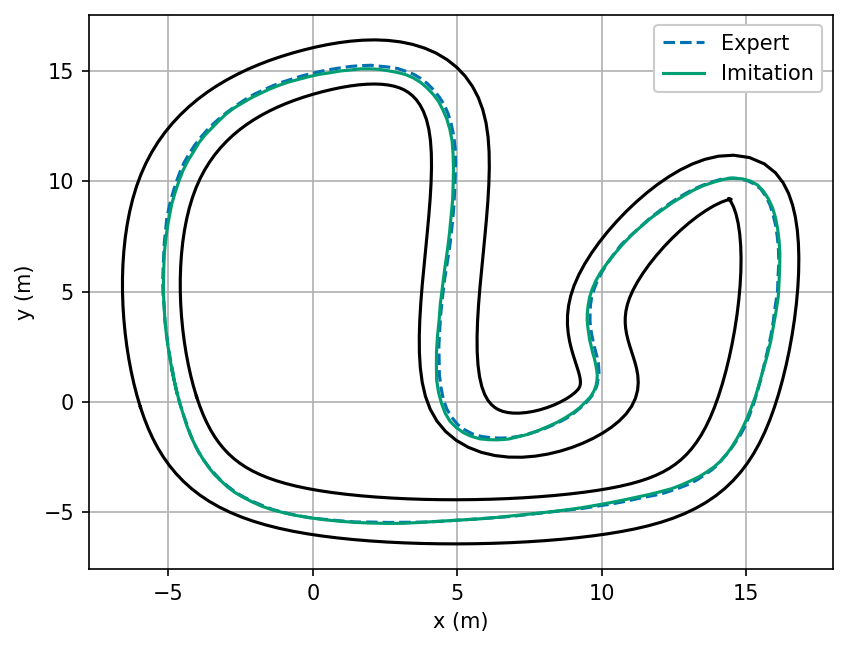

In [ ]:
# Simulate the trajectory
n_laps = 1
simulator = Simulator()

t = np.arange(0, Config.duration * n_laps, Config.time_step)
x_imitation = np.zeros((len(t), A_learnt.shape[0]))

# Use the same starting point as the expert
x_imitation[0] = x_expert[0]

# Detaching our model from the computational graph
theta = theta_task3.detach().cpu().numpy()

error = np.zeros(len(t) - 1)

with torch.no_grad():
    for i in range(len(t) - 1):
        x_ref = calculate_reference(x_imitation[i], x_expert, horizon=1)[0]
        diff = x_imitation[i] - x_ref
        error[i] = (diff[:2]**2).mean() + (diff[2:]**2).mean()
        u_imitation = (diff) @ theta.T
        x_imitation[i + 1] = simulator.step(x_imitation[i], u_imitation)

plot_vs_expert(x_imitation, "Imitation", x_expert, track)

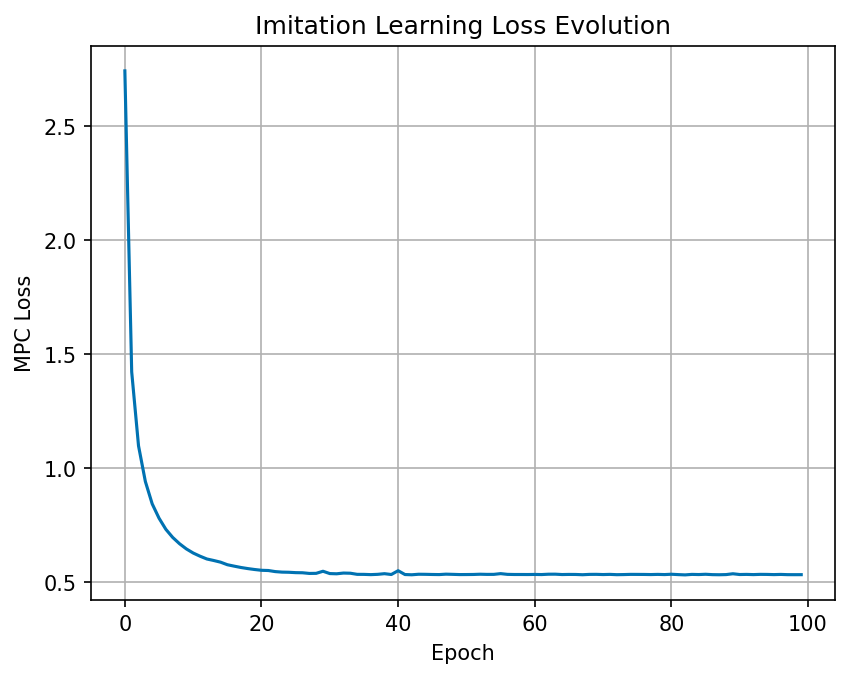

In [ ]:
# Plot the loss evolution
plt.plot(epoch_loss)
plt.xlabel("Epoch")
plt.ylabel("MPC Loss")
plt.title("Imitation Learning Loss Evolution")
plt.grid()

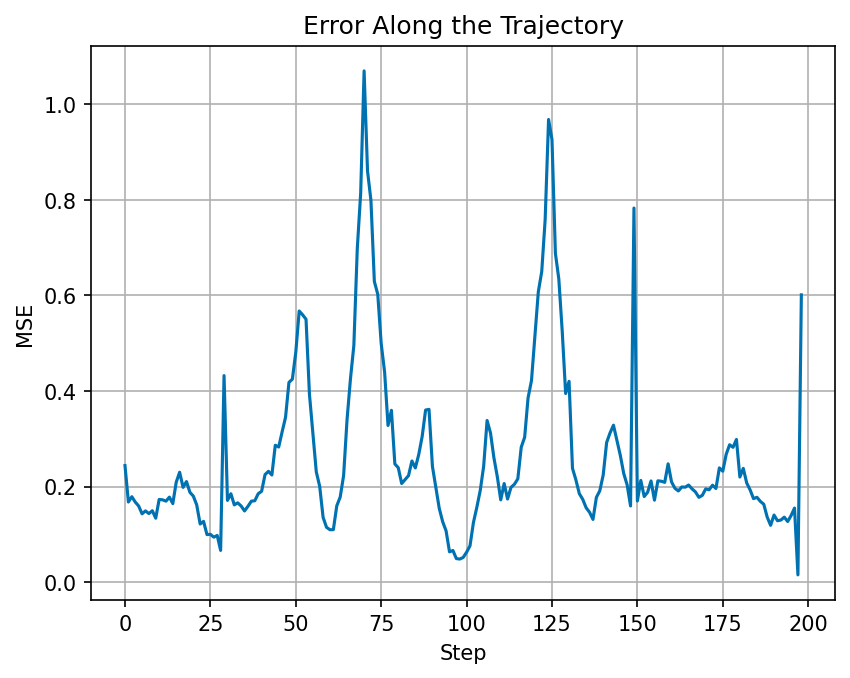

In [ ]:
# Plot the trajectory error
plt.figure()
plt.plot(error)
plt.xlabel("Step")
plt.ylabel("MSE")
plt.title("Error Along the Trajectory")
plt.grid(True)
plt.show()